In [1]:
from __future__ import division
import numpy as np
import pandas as pd
import seaborn as sns
%pylab inline
pylab.rcParams['figure.figsize'] = (12.0, 6.0) # set size of figures"
plt.rcParams.update({'font.size': 24})
pd.options.display.max_rows=50
from nvd3 import multiBarHorizontalChart, multiBarChart, pieChart
from collections import defaultdict

Populating the interactive namespace from numpy and matplotlib
loaded nvd3 IPython extension
run nvd3.ipynb.initialize_javascript() to set up the notebook
help(nvd3.ipynb.initialize_javascript) for options


In [131]:
Events=pd.read_csv('/Users/attiladobi/Downloads/Query_all.csv',index_col='time')
#convert unix time to timestamp and set as primary index
Events['Date'] = pd.to_datetime(Events.index,unit='ms')
Events=Events.set_index('Date')
Events['hour'] = pd.to_numeric(Events.index.hour)
Events['day'] = pd.to_numeric(Events.index.day)
Events['month'] = pd.to_numeric(Events.index.month)
Events['year'] = pd.to_numeric(Events.index.year)

<h1> Remove zenysis user actions </h1>

In [132]:
zen_cut=(~Events['properties.$os'].str.contains('OS') & ~Events['distinct_id'].str.contains('ian')\
                  & ~Events['distinct_id'].str.contains('zenysis'))
EZ=Events[zen_cut]
EZ.head()

,name,distinct_id,sampling_factor,properties.$browser,properties.$browser_version,properties.$city,properties.$current_url,properties.$initial_referrer,properties.$initial_referring_domain,properties.$lib_version,...,properties.hmis_indicator_4486,properties.hmis_indicator_3973,properties.newSelectionsFilters.hmis_indicator_3205.ranges.3.color,properties.newSelectionsFilters.hmis_indicator_3205.ranges.3.max,properties.newSelectionsFilters.hmis_indicator_3205.ranges.3.min,properties.TotalTargetPopulation,hour,day,month,year
Date,,,,,,,,,,,,,,,,,,,,,
2016-02-08 09:21:28,Main query view,massoud,1,Firefox,45.0,Addis Ababa,http://preview.zenysis.com/,$direct,$direct,2.7.2,...,NaN,NaN,NaN,NaN,NaN,NaN,9,8,2,2016
2016-10-27 11:09:53,Main query view,m_berdnikov@hotmail.com,1,Internet Explorer,11.0,Centurion,http://nacosa.zenysis.com/query,$direct,$direct,2.9.16,...,NaN,NaN,NaN,NaN,NaN,NaN,11,27,10,2016
2016-10-27 11:10:04,Dashboard view,m_berdnikov@hotmail.com,1,Internet Explorer,11.0,Centurion,http://nacosa.zenysis.com/dashboard,$direct,$direct,2.9.16,...,NaN,NaN,NaN,NaN,NaN,NaN,11,27,10,2016
2016-10-27 11:10:12,Main query view,m_berdnikov@hotmail.com,1,Internet Explorer,11.0,Centurion,http://nacosa.zenysis.com/query,$direct,$direct,2.9.16,...,NaN,NaN,NaN,NaN,NaN,NaN,11,27,10,2016
2016-10-27 11:18:57,Updated healthIndicators selection,m_berdnikov@hotmail.com,1,Internet Explorer,11.0,Centurion,http://nacosa.zenysis.com/query,$direct,$direct,2.9.16,...,NaN,NaN,NaN,NaN,NaN,NaN,11,27,10,2016


<h1> look for new searches containing "selections" </h1>

In [133]:
pre_filters=Events.columns[Events.columns.str.contains('newSelections')]
set([filter_type.split('.')[-1] for filter_type in pre_filters])

{'color', 'excludeZeroes', 'max', 'maxBound', 'min', 'minBound', 'title'}

<h1> set of event names </h1>

In [134]:
set(EZ['name'])

{'Apply selections filter',
 'Change result view',
 'Click save query button',
 'Dashboard view',
 'Data status view',
 'Error: no fields selected',
 'Export to Excel',
 'Facilities map view',
 'Flagged issue',
 'Invite form submitted',
 'Invite view',
 'Login view',
 'Main query view',
 'Remove query from dashboard',
 'Reset selections',
 'Resource mobilization view',
 'Run query',
 'Run query complete',
 'Saved query to dashboard',
 'Sidebar toggle',
 'Toggle legend series',
 'Updated date selection',
 'Updated denominator selection',
 'Updated endDate selection',
 'Updated geography selection',
 'Updated healthIndicators selection',
 'Updated partners selection',
 'Updated startDate selection',
 'Updated targets selection',
 'Upload data',
 'Upload view',
 'Uploaded file(s)',
 'js error'}

<h1> Analyze of post query complete actions </h1>

In [308]:
names=['Run query complete','Apply selections filter','Change result view', 'Click save query button','Export to Excel','Sidebar toggle','Toggle legend series']
total_queries=EZ.loc[(EZ['name']=='Run query complete')]['name'].count() #selection is listed with "Run query complete"
xbins=[1,2,3,4,5]
S=dict()
S['total']=total_queries

for name in names:
    Num=EZ.loc[(EZ['name']==name)]['name'].count()
    Num_per_day=EZ.loc[(EZ['name']==name)].groupby(['distinct_id','year','month','day'])['name'].count()
    Num_per_day_per_query=(EZ.loc[(EZ['name']==name)].groupby(['distinct_id','month','day'])['name'].count()\
/EZ.loc[(EZ['name']=='Run query complete')].groupby(['distinct_id','month','day'])['name'].count()).replace(nan,0)
    S[name]={'count':Num, 'count_daily':Num_per_day, 'count_daily_per_query':Num_per_day_per_query}

In [309]:
S['Change result view']['count_daily_per_query'].values.std()

1.3760717111493157

In [310]:
#EZ.loc[(EZ['name']=='Run query complete')].groupby(['distinct_id','month','day'])['name'].count()
#/EZ.loc[(EZ['name']=='Run query complete')].groupby(['distinct_id','month','day'])['name'].count()).dropna()

<h3> violin plot of average actions per day per query </h1>

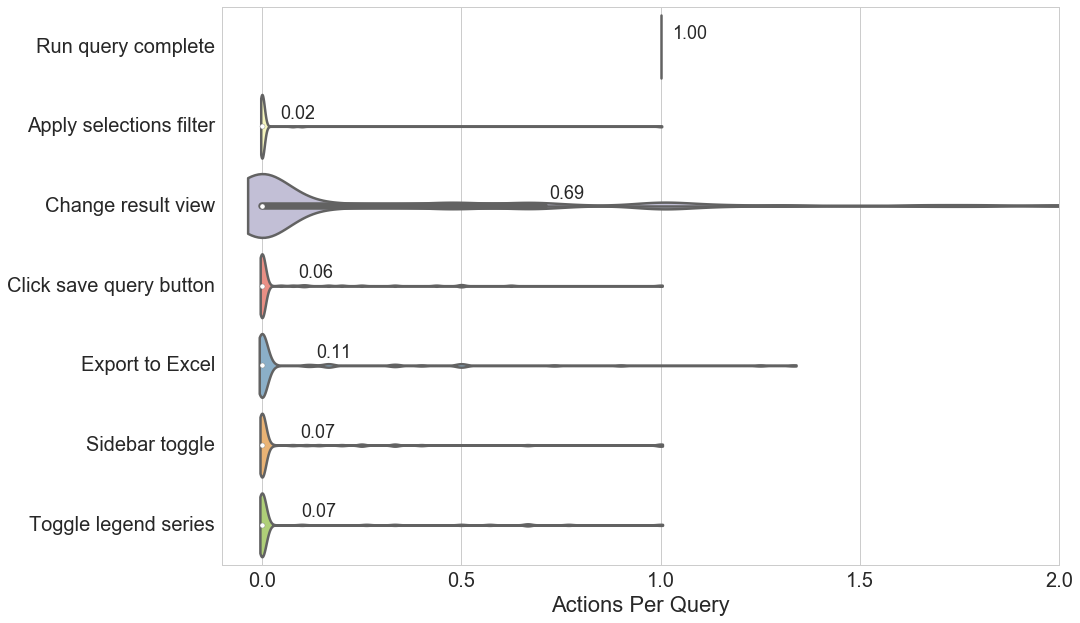

In [327]:
data=[]
aves=[]
for name in names:
    data.append(S[name]['count_daily_per_query'].values) #num select is the raw data before doing hist
    aves.append(mean(S[name]['count_daily_per_query'].values))
    
sns.set_style("whitegrid")
fig=figure()
ax = sns.violinplot(xlabel=names, data=data,
                      scale='width', palette="Set3",orient='h',gridsize=1000,bw=.05,cut=.5)
fig.set_size_inches(15, 10)
sns.set_context("notebook", font_scale=2, rc={"lines.linewidth": 2.5})
plt.xlabel("Actions Per Query")
plt.yticks(range(len(names)), names)
xlim(-.1,2.0)
for y,val in zip(range(len(names)),aves):
    text(val+0.03,y-.1,'{:.2f}'.format(val),fontsize=18)

<h3> volin plot of number selected per query (when non-zero) </h3>

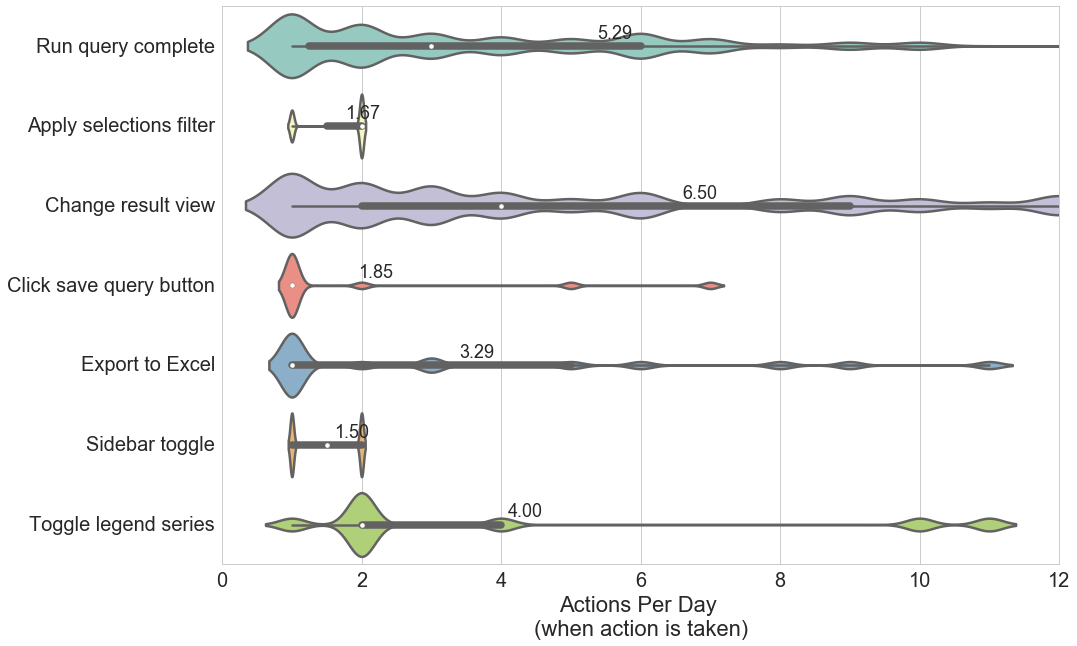

In [169]:
data=[]
aves=[]
for name in names:
    data.append(S[name]['count_daily'].values) #num select is the raw data before doing hist
    aves.append(mean(S[name]['count_daily'].values))
    
sns.set_style("whitegrid")
fig=figure()
ax = sns.violinplot(xlabel=names, data=data,
                     scale="width", palette="Set3",orient='h',gridsize=1000,bw=.05)
fig.set_size_inches(15, 10)
sns.set_context("notebook", font_scale=2, rc={"lines.linewidth": 2.5})
plt.xlabel("Actions Per Day \n(when action is taken)")
plt.yticks(range(len(names)), names)
xlim(0,12)
for y,val in zip(range(len(names)),aves):
    text(val+0.1,y-.1,'{:.2f}'.format(val),fontsize=18)

<h1> Plot the most used post query </h1>

In [171]:
xdata=names[1:]
count=[]
non_count=[]
for name in xdata:
    count.append(S[name]['count'])
    non_count.append(S['total']-S[name]['count'])
notSel=np.array(non_count) 
Sel=np.array(count)
#non_zero=notSel>0
sort_index=notSel.argsort()

# Open File to write the D3 Graph
#output_file = open('SA_services.html', 'w')

kwargs1 = {"fontSize": '50'}

chart = multiBarChart(name='preSelect', width=2000, height=400, x_axis_format=None,color_category="category10",**kwargs1)
chart.create_y_axis('yAxis','Percent used after running a query')

#xdata = ['one' , 'two', 'three', 'four']
xdata=np.array(xdata)[sort_index]
ydata1 = Sel[sort_index]/S['total']*100
ydata2 = notSel[sort_index]/S['total']*100

chart.add_serie(name="Used", y=ydata1, x=xdata, **kwargs1)
chart.add_serie(name="Not Used", y=ydata2, x=xdata, **kwargs1)

chart.buildhtml()

#output_file.write(chart.htmlcontent)
# close Html file
#output_file.close()

display(chart)

<h1> Find out details on post selections </h1>

In [223]:
post_filters=EZ.columns[EZ.columns.str.contains('newSelection')]
names=list(set([filter_type.split('.')[-1] for filter_type in post_filters]))
names

['min', 'color', 'max', 'maxBound', 'title', 'minBound', 'excludeZeroes']

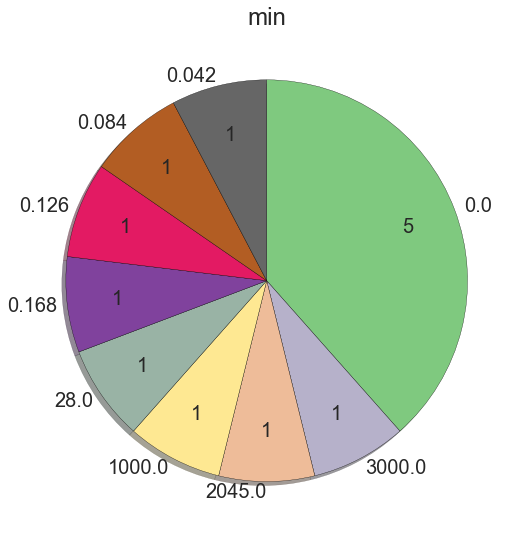

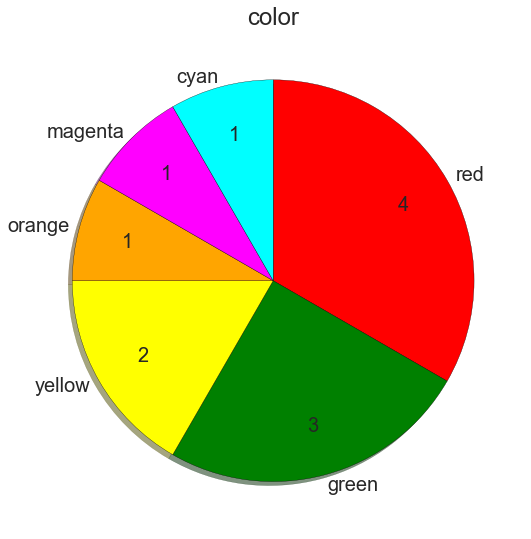

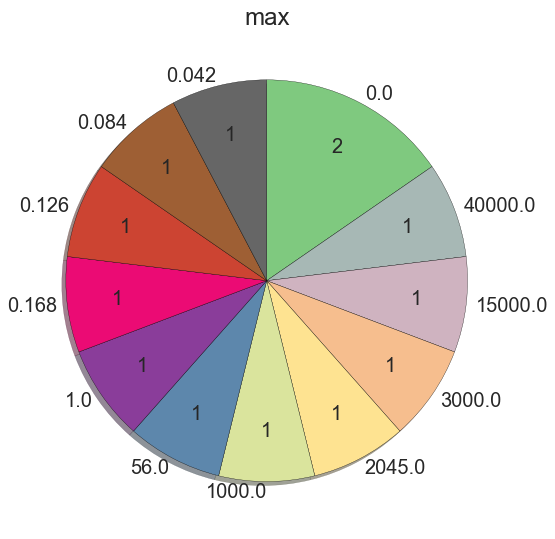

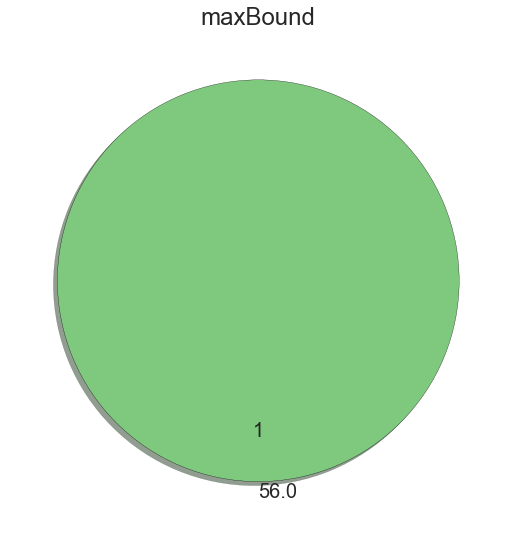

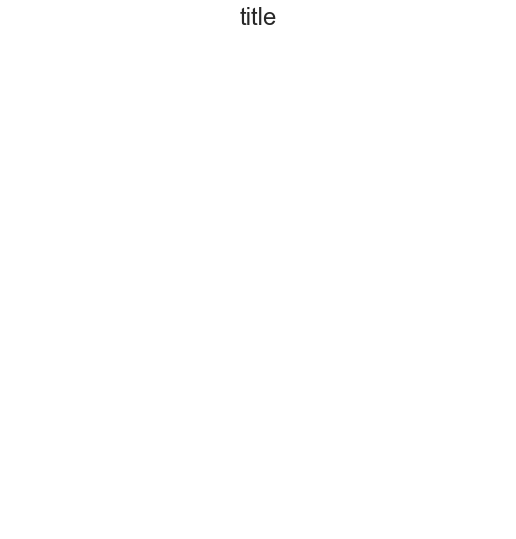

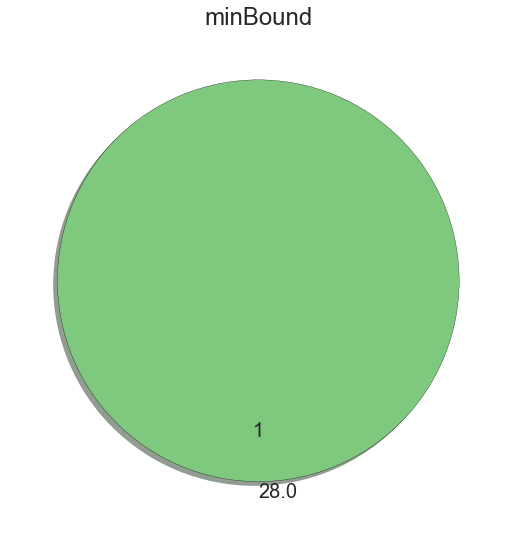

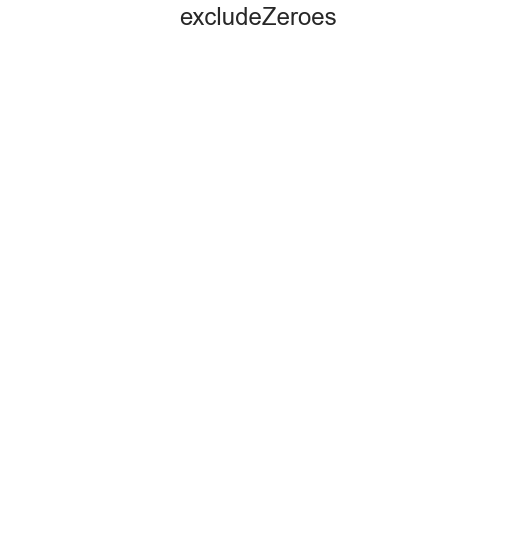

In [291]:
for name in names:
    Filter=EZ.columns[EZ.columns.str.contains('newSelection') & EZ.columns.str.contains(name)]
    Bins=defaultdict(lambda:0)
    vals=EZ.loc[(EZ['name']=='Apply selections filter')][Filter].stack().values
    for val in vals:
        Bins[val]+=1 
    breakdown=pd.Series(Bins,name=name).sort_values(ascending=False)
    if name =='color':
        make_pie(breakdown,colorlabels=True)
    else:
        make_pie(breakdown)

In [290]:
def make_pie(breakdown,topn=8,colorlabels=False,other=False):
    pylab.rcParams['figure.figsize'] = (9.0, 9.0) # set size of figures"
    plt.rcParams.update({'font.size': 20})
    figure()
    name=breakdown.name
    if other:
        s_other = pd.Series([breakdown[topn:].sum()], index=['other'])
        breakdown=breakdown[:topn].append(s_other)
    # The slices will be ordered and plotted counter-clockwise.
    labels=breakdown.index #labels = [label.split('@')[0] for label in actions_cut.index]
    sizes = breakdown.values
    total=sum(sizes)
    #explode = (0.01, 0.01, 0, 0.01)  # only "explode" the 2nd slice (i.e. 'Hogs')
    cmap = plt.cm.Accent
    if colorlabels:
        colors=labels
    else:
        colors = cmap(np.linspace(0., 1., len(labels)))
    
    patches, texts, autotexts= plt.pie(sizes, labels=labels, colors=colors, 
            autopct=lambda(p): '{:.0f}'.format(p * total / 100),
            pctdistance=0.75, labeldistance=1.05, shadow=True, startangle=90,counterclock=False)
    [text.set_fontsize(20) for text in texts]
    plt.title(name)
    
#make_pie(breakdown,8)

<h1> Make with D3JS </h1>

In [269]:
def make_pie_d3(breakdown):
    # Open File to write the D3 Graph
    #output_file = open('SA_pie_target-to-spend.html', 'w')
    name=breakdown.axes[0].name.split('.')[-1]
    kwargs1 = {"fontSize": '100'}

    chart = pieChart(name=name,width=800, height=600,  color_category='category10',**kwargs1)
    xdata = [label.split('T0')[0] for label in breakdown.index]
    #xdata = ['one' , 'two', 'three', 'four']
    ydata1 = breakdown.values
    extra_serie = {"tooltip": {"y_start": "", "y_end": "%"}}

    chart.add_serie(title=name,name="Serie 1", y=ydata1, x=xdata, extra=extra_serie,**kwargs1)
    chart.buildhtml()

    #output_file.write(chart.htmlcontent)
    # close Html file
    #output_file.close()

    display(chart)
#make_pie_d3(breakdown)